In [10]:
import glob
import pandas as pd
import json
import pickle as pkl

import numpy as np
import matplotlib.pyplot as plt
import hist
import mplhep
import matplotlib as mpl
from matplotlib.lines import Line2D

mpl.rcParams["font.size"] = 16
mpl.rcParams["lines.linewidth"] = 2
mpl.rcParams["grid.color"] = "#CCCCCC"
mpl.rcParams["grid.linewidth"] = 0.5
mpl.rcParams["figure.edgecolor"] = "none"

import matplotlib.ticker as mticker
formatter = mticker.ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-3, 3))
mplhep.style.use(["CMS", "firamath"])

In [2]:
def get_sum_sumgenweight(pkl_files, year, sample):
    sum_sumgenweight = 0
    for ifile in pkl_files:
        # load and sum the sumgenweight of each
        with open(ifile, "rb") as f:
            metadata = pkl.load(f)
        sum_sumgenweight = sum_sumgenweight + metadata[sample][year]["sumgenweight"]
    return sum_sumgenweight

def get_xsecweight(pkl_files, year, sample, is_data, luminosity):
    if not is_data:
        # find xsection
        f = open("../fileset/xsec_pfnano.json")
        xsec = json.load(f)
        f.close()
        try:
            xsec = eval(str((xsec[sample])))
        except ValueError:
            print(f"sample {sample} doesn't have xsecs defined in xsec_pfnano.json so will skip it")
            return None

        # get overall weighting of events.. each event has a genweight...
        # sumgenweight sums over events in a chunk... sum_sumgenweight sums over chunks
        xsec_weight = (xsec * luminosity) / get_sum_sumgenweight(pkl_files, year, sample)
    else:
        xsec_weight = 1
    return xsec_weight

In [25]:
vpt_axis = hist.axis.Regular(
    40, 0, 3000, name="vpt", label=r"LHE V p$_T$ [GeV]"
)
lpt_axis = hist.axis.Regular(
    40, 0, 1000, name="leppt", label=r"Reco Lepton p$_T$ [GeV]"
)
ht_axis = hist.axis.Regular(
    40, 0, 3000, name="ht", label=r"LHE HT [GeV]"
)
sample_axis = hist.axis.StrCategory([], name="scat", growth=True)
h_vpt = hist.Hist(vpt_axis, sample_axis)
h_vpt_noweight = hist.Hist(vpt_axis, sample_axis)

h_ht = hist.Hist(ht_axis, sample_axis)
h_ht_ind = hist.Hist(ht_axis, sample_axis)

h_vpt_nocorr = hist.Hist(vpt_axis, sample_axis)
h_vpt_oldcorr = hist.Hist(vpt_axis, sample_axis)
h_vpt_noewkcorr = hist.Hist(vpt_axis, sample_axis)

h_lpt = hist.Hist(lpt_axis, sample_axis)

odir = "/eos/uscms/store/user/cmantill/boostedhiggs/Jan5_selvjets_2018/"
ch = "mu"
year = "2018"
samples_dict = {
    "WJetsNLO": [
        #"WJetsToLNu_0J",
        "WJetsToLNu_1J",
        "WJetsToLNu_2J",
    ],
    "WJetsLO-HT": [
        "WJetsToLNu_TuneCP5_13TeV-madgraphMLM",
        #"WJetsToLNu_HT-70To100",
        #"WJetsToLNu_HT-100To200",
        "WJetsToLNu_HT-200To400",
        "WJetsToLNu_HT-400To600",
        "WJetsToLNu_HT-600To800",
        "WJetsToLNu_HT-800To1200",
        "WJetsToLNu_HT-1200To2500",
        "WJetsToLNu_HT-2500ToInf",
    ],
    "DYJetsLO-HT": [
        #"DYJetsToLL_M-10to50",
        "DYJetsToLL_M-50",
        #"DYJetsToLL_M-50_HT-70to100",
        "DYJetsToLL_M-50_HT-100to200",
        "DYJetsToLL_M-50_HT-200to400",
        "DYJetsToLL_M-50_HT-400to600",
        "DYJetsToLL_M-50_HT-600to800",
        "DYJetsToLL_M-50_HT-800to1200",
        "DYJetsToLL_M-50_HT-1200to2500",
        "DYJetsToLL_M-50_HT-2500toInf",
    ],
    "DYJetsNLO": [
        "DYJetsToLL_LHEFilterPtZ-0To50",
        "DYJetsToLL_LHEFilterPtZ-50To100",
        "DYJetsToLL_LHEFilterPtZ-100To250",
        "DYJetsToLL_LHEFilterPtZ-250To400",
        "DYJetsToLL_LHEFilterPtZ-400To650",
        "DYJetsToLL_LHEFilterPtZ-650ToInf",
    ],
}

for key,samples in samples_dict.items():
    for sample in samples:
        parquet_files = glob.glob(f"{odir}/{sample}/outfiles/*_{ch}.parquet")
        pkl_files = glob.glob(f"{odir}/{sample}/outfiles/*.pkl")
        print(sample)

        columns = [
            "LHE_HT", 
            "LHE_Vpt", 
            f"weight_{ch}",
            "ewk_corr", "oldqcd_corr", "qcd_corr", 
            "lep_pt"
        ]
        data = pd.read_parquet(parquet_files, columns=columns)

        luminosity = 59781.96

        event_weight = get_xsecweight(pkl_files, year, sample, False, luminosity)
        event_weight *= data[f"weight_{ch}"]

        if sample=="WJetsToLNu_TuneCP5_13TeV-madgraphMLM" or sample=="DYJetsToLL_M-50":
            selection = (data["LHE_HT"] < 70)
            data = data[selection]
            event_weight = event_weight[selection]

        if len(data) <= 0: continue
        leppt = data["lep_pt"].values
        h_lpt.fill(leppt, key, weight=event_weight)

        hpt = data["LHE_Vpt"].values
        h_vpt.fill(hpt, key, weight=event_weight)
        h_vpt_noweight.fill(hpt, key)

        if "NLO" in sample:
            h_vpt_nocorr.fill(hpt, key, weight=event_weight)
        else:
            qcd_corr = data["qcd_corr"].values
            inv_qcd_corr = np.nan_to_num(1/data["qcd_corr"])
            w = event_weight*inv_qcd_corr
            h_vpt_nocorr.fill(hpt, key, weight=w)

            w = event_weight*inv_qcd_corr*data["oldqcd_corr"]
            h_vpt_oldcorr.fill(hpt, key, weight=w)
        
        ht = data["LHE_HT"].values
        h_ht.fill(ht, key, weight=event_weight)

        h_ht_ind.fill(ht, sample, weight=event_weight)

WJetsToLNu_1J
WJetsToLNu_2J
WJetsToLNu_TuneCP5_13TeV-madgraphMLM
WJetsToLNu_HT-200To400
WJetsToLNu_HT-400To600
WJetsToLNu_HT-600To800
WJetsToLNu_HT-800To1200
WJetsToLNu_HT-1200To2500
WJetsToLNu_HT-2500ToInf
DYJetsToLL_M-50
DYJetsToLL_M-50_HT-100to200
DYJetsToLL_M-50_HT-200to400
DYJetsToLL_M-50_HT-400to600
DYJetsToLL_M-50_HT-600to800
DYJetsToLL_M-50_HT-800to1200
DYJetsToLL_M-50_HT-1200to2500
DYJetsToLL_M-50_HT-2500toInf
DYJetsToLL_LHEFilterPtZ-0To50
DYJetsToLL_LHEFilterPtZ-50To100
DYJetsToLL_LHEFilterPtZ-100To250
DYJetsToLL_LHEFilterPtZ-250To400
DYJetsToLL_LHEFilterPtZ-400To650
DYJetsToLL_LHEFilterPtZ-650ToInf


Comparing statistics

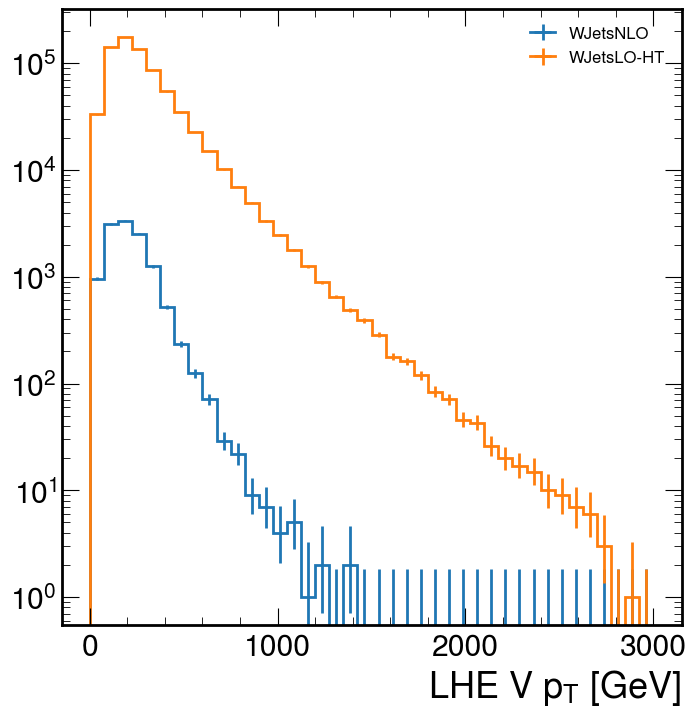

In [35]:
fig, ax = plt.subplots(figsize=(8, 8))
legend_elements = []
for key in ["WJetsNLO", "WJetsLO-HT"]:
    h = h_vpt_noweight[{"scat": key}]
    mplhep.histplot(h, lw=2, flow="none", label=key)
ax.legend(fontsize=12)
ax.set_yscale("log")
fig.savefig("wpt_stats.png")

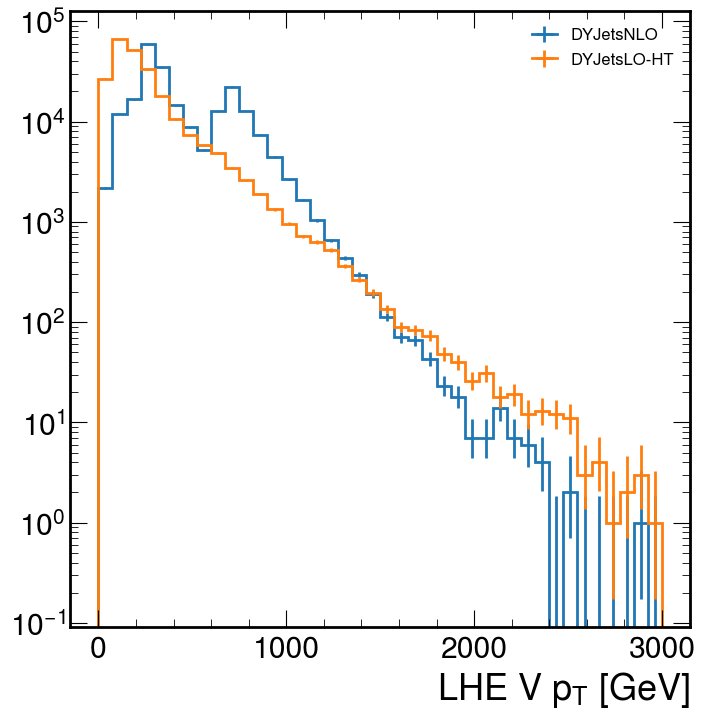

In [36]:
fig, ax = plt.subplots(figsize=(8, 8))
legend_elements = []
for key in ["DYJetsNLO", "DYJetsLO-HT"]:
    h = h_vpt_noweight[{"scat": key}]
    mplhep.histplot(h, lw=2, flow="none", label=key)
ax.legend(fontsize=12)
ax.set_yscale("log")
fig.savefig("zpt_stats.png")

Lepton pT

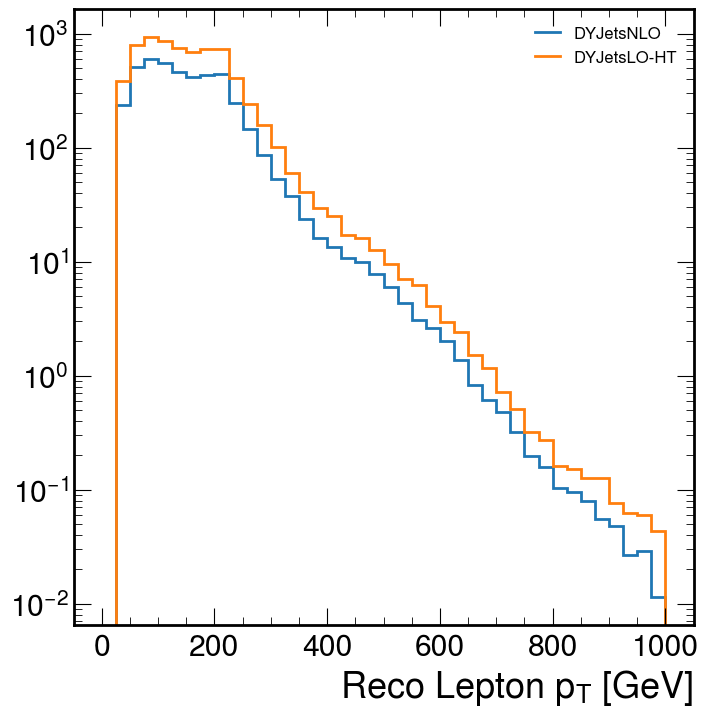

In [44]:
fig, ax = plt.subplots(figsize=(8, 8))
legend_elements = []
for key in ["DYJetsNLO", "DYJetsLO-HT"]:
    h = h_lpt[{"scat": key}]
    mplhep.histplot(h, lw=2, flow="none", label=key)
ax.legend(fontsize=12)
ax.set_yscale("log")
fig.savefig("w_leppt.png")

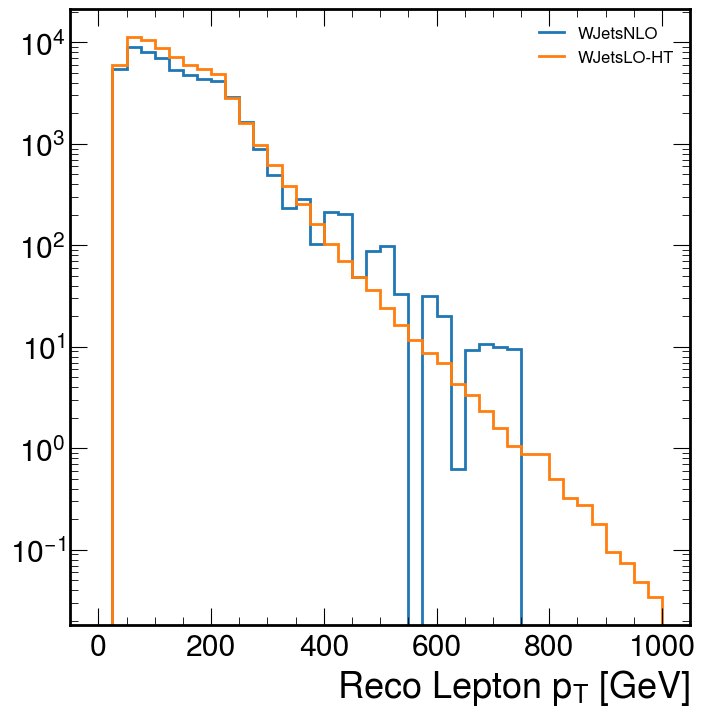

In [38]:
fig, ax = plt.subplots(figsize=(8, 8))
legend_elements = []
for key in ["WJetsNLO", "WJetsLO-HT"]:
    h = h_lpt[{"scat": key}]
    mplhep.histplot(h, lw=2, flow="none", label=key)
ax.legend(fontsize=12)
ax.set_yscale("log")
fig.savefig("z_leppt.png")

V pT and HT for LO/NLO reweighted with cross section, QCD (LO), and EWK

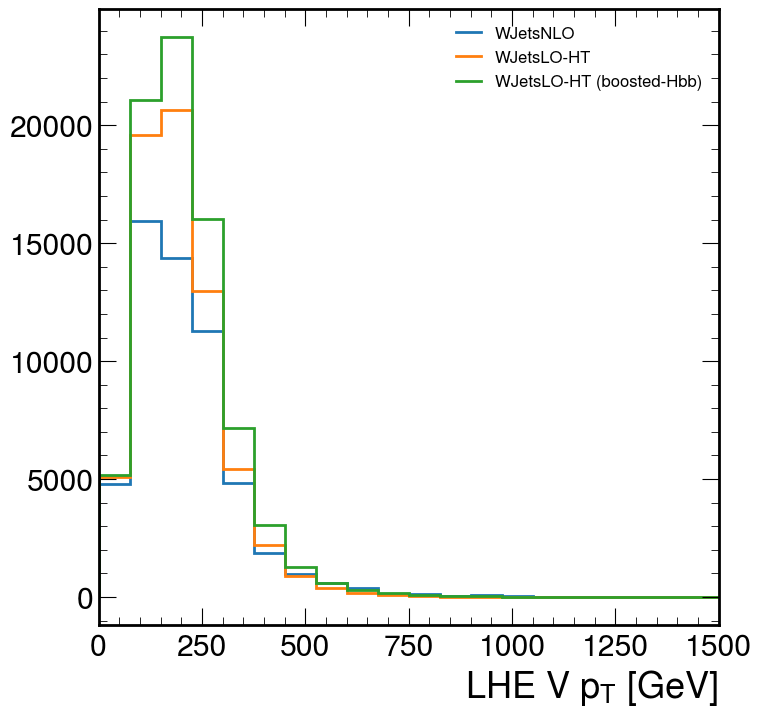

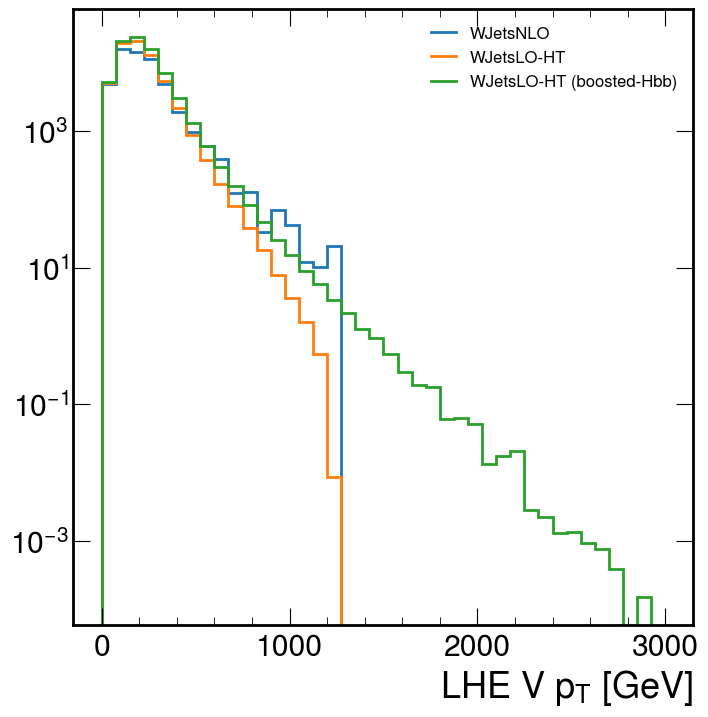

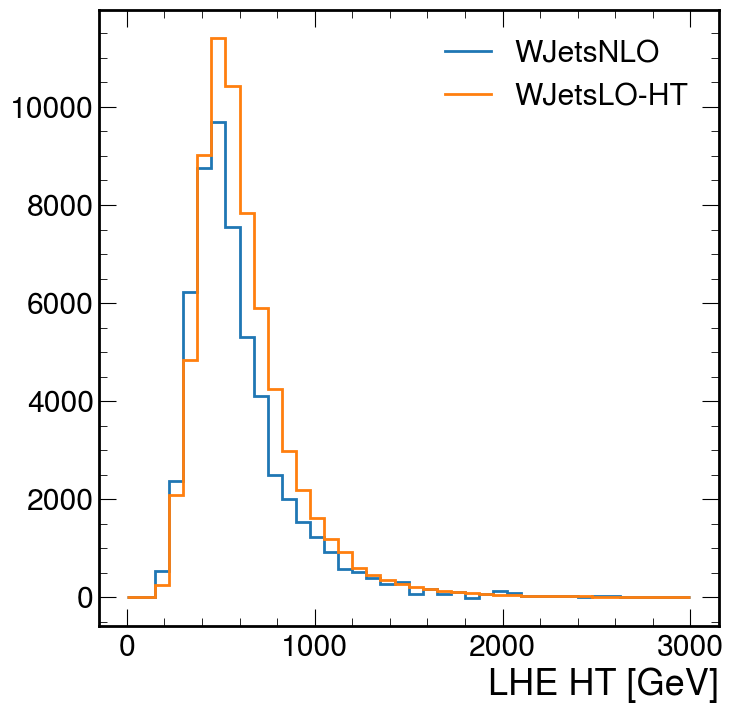

In [39]:
fig, ax = plt.subplots(figsize=(8, 8))
for key in ["WJetsNLO", "WJetsLO-HT"]:
    h = h_vpt[{"scat": key}]
    mplhep.histplot(h, lw=2, flow="none", label=key)
mplhep.histplot(h_vpt_oldcorr[{"scat": "WJetsLO-HT"}], lw=2, flow="none", label="WJetsLO-HT (boosted-Hbb)")
ax.legend(fontsize=12)
ax.set_xlim(0, 1500)
fig.savefig("wpt_all.png")

fig, ax = plt.subplots(figsize=(8, 8))
for key in ["WJetsNLO", "WJetsLO-HT"]:
    h = h_vpt[{"scat": key}]
    mplhep.histplot(h, lw=2, flow="none", label=key)
mplhep.histplot(h_vpt_oldcorr[{"scat": "WJetsLO-HT"}], lw=2, flow="none", label="WJetsLO-HT (boosted-Hbb)")
ax.legend(fontsize=12)
ax.set_yscale("log")
fig.savefig("wpt_all_log.png")

fig, ax = plt.subplots(figsize=(8, 8))
legend_elements = []
for key in ["WJetsNLO", "WJetsLO-HT"]:
    h = h_ht[{"scat": key}]
    mplhep.histplot(
        h,
        lw=2,
        flow="none",
        label=key,
    )
ax.legend()
fig.savefig("wht_all.png")

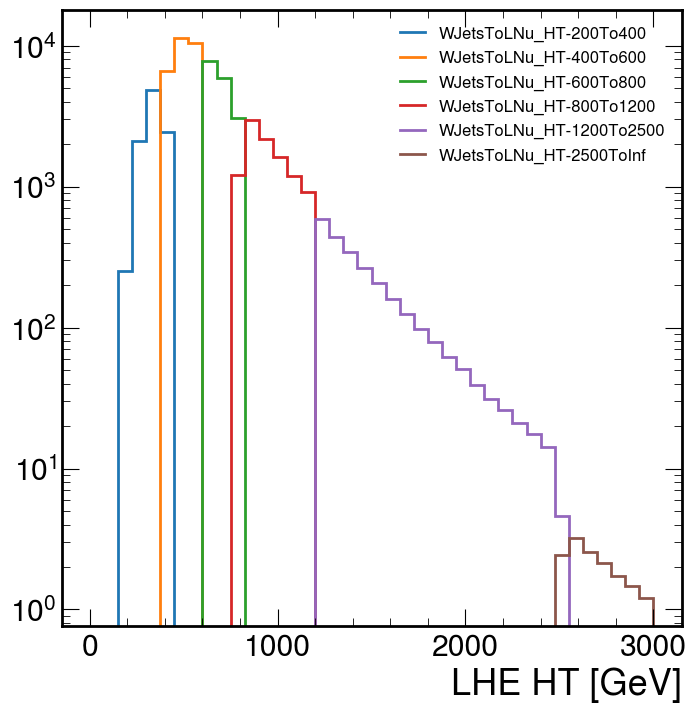

In [40]:
fig, ax = plt.subplots(figsize=(8, 8))
legend_elements = []
for key in samples_dict["WJetsLO-HT"]:
    if key == "WJetsToLNu_TuneCP5_13TeV-madgraphMLM": continue
    h = h_ht_ind[{"scat": key}]
    mplhep.histplot(
        h,
        lw=2,
        #density=True,
        flow="none",
        label=key,
    )
ax.legend(fontsize=12)
ax.set_yscale("log")
fig.savefig("wht_bins.png")

With and without QCD corrections

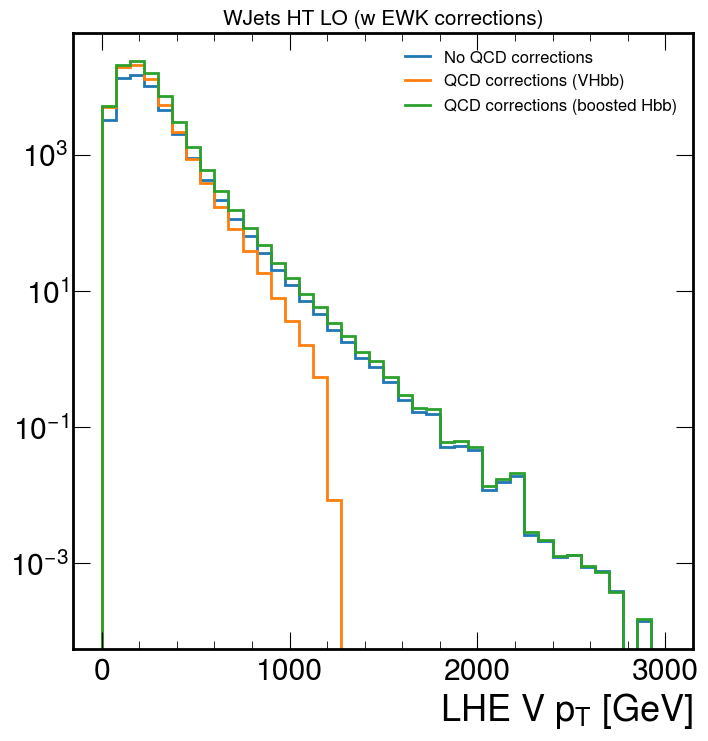

In [41]:
fig, ax = plt.subplots(figsize=(8, 8))
legend_elements = []
h1 = h_vpt[{"scat": "WJetsLO-HT"}]
h2 = h_vpt_nocorr[{"scat": "WJetsLO-HT"}]
h3 = h_vpt_oldcorr[{"scat": "WJetsLO-HT"}]
mplhep.histplot(h2, lw=2, flow="none", label="No QCD corrections")
mplhep.histplot(h1, lw=2, flow="none", label="QCD corrections (VHbb)")
mplhep.histplot(h3, lw=2, flow="none", label="QCD corrections (boosted Hbb)")
ax.legend(fontsize=12)
ax.set_title("WJets HT LO (w EWK corrections)", fontsize=15)
ax.set_yscale("log")
fig.savefig("wpt_corrections.png")

DYJets

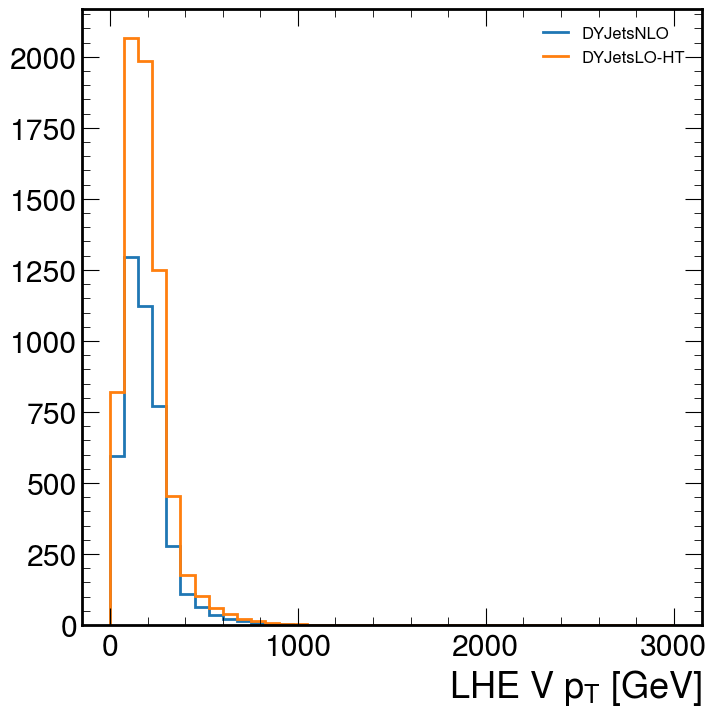

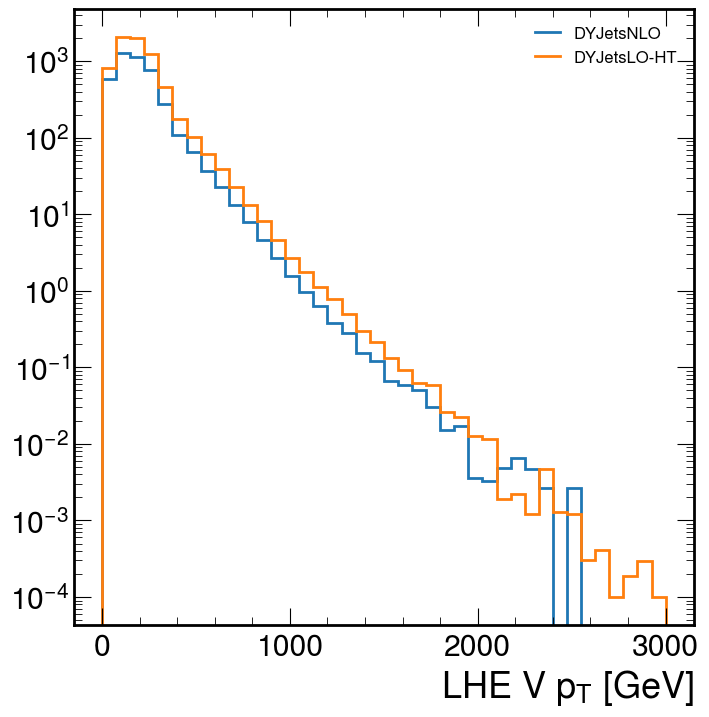

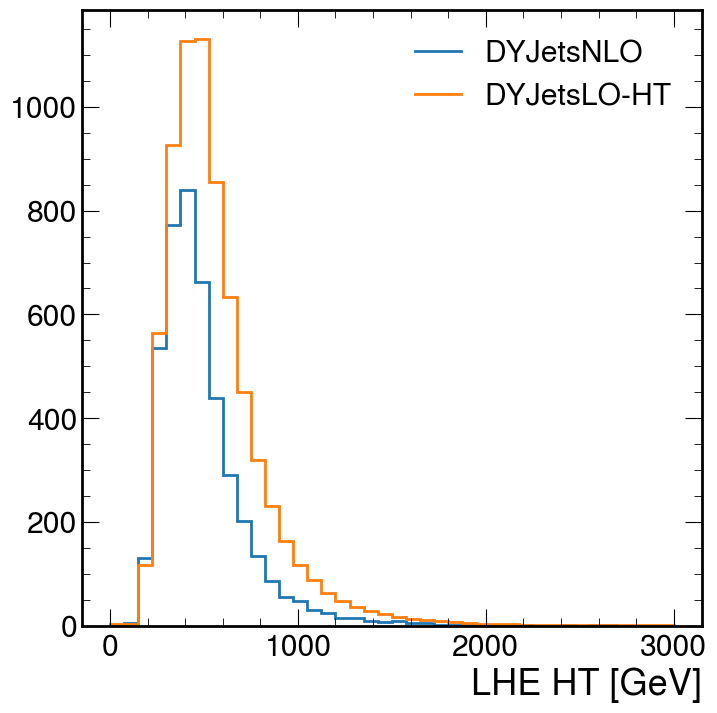

In [42]:
fig, ax = plt.subplots(figsize=(8, 8))
for key in ["DYJetsNLO", "DYJetsLO-HT"]:
    h = h_vpt[{"scat": key}]
    mplhep.histplot(h, lw=2, flow="none", label=key)
ax.legend(fontsize=12)
fig.savefig("zpt_all.png")

fig, ax = plt.subplots(figsize=(8, 8))
for key in ["DYJetsNLO", "DYJetsLO-HT"]:
    h = h_vpt[{"scat": key}]
    mplhep.histplot(h, lw=2, flow="none", label=key)
ax.legend(fontsize=12)
ax.set_yscale("log")
fig.savefig("zpt_all_log.png")

fig, ax = plt.subplots(figsize=(8, 8))
legend_elements = []
for key in ["DYJetsNLO", "DYJetsLO-HT"]:
    h = h_ht[{"scat": key}]
    mplhep.histplot(
        h,
        lw=2,
        flow="none",
        label=key,
    )
ax.legend()
fig.savefig("zht_all.png")

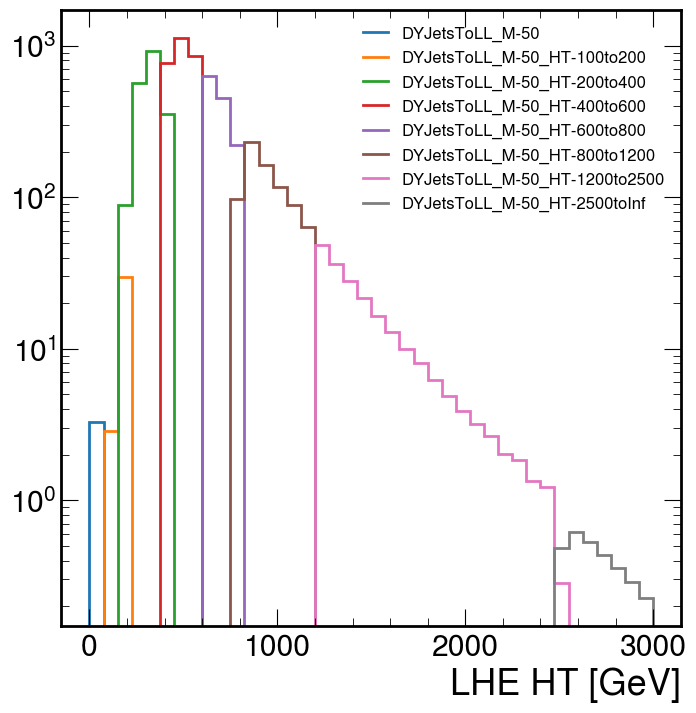

In [43]:
fig, ax = plt.subplots(figsize=(8, 8))
legend_elements = []
for key in samples_dict["DYJetsLO-HT"]:
    h = h_ht_ind[{"scat": key}]
    mplhep.histplot(
        h,
        lw=2,
        #density=True,
        flow="none",
        label=key,
    )
ax.legend(fontsize=12)
ax.set_yscale("log")
fig.savefig("zht_bins.png")